# shop results

## goal

* find factors influencing this shop's results
* predict results

In [1]:
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Load data

In [2]:
from datetime import datetime
from os import path, scandir

daily_datadir = "./data/CaisseJour/"
datadirs = [path.join(daily_datadir, d.name) for d in scandir(daily_datadir)]
data_files = [
    path.join(datadir, file.name)
    for datadir in datadirs
    for file in scandir(datadir)
]

In [3]:
def parse_caisse(filename, keywords=("Chiffre", "TVA", "nombre", "moyen", "ticket")):
    """Parse file "caisse jour"
    
    Args:
        filename (string): file to parse
        keywords (list): list of keywords for  one line data
    """
    data = {}
    with open(filename, "br") as fd:
        for line in fd:
            line = line.decode("Windows-1252",errors="ignore")
            if "à" in line:
                # try with date
                try:
                    date = [int(d) for d in  line.split(" ")[0].split("/")]
                except ValueError:
                    # "à" in cocktail name
                    continue
                data["date"] = datetime(date[2], date[1], date[0])
            elif any(keyword in line for keyword in keywords):
                value = line.split(";")[1]
                value = value.strip("€ \r\n")
                try:
                    # parse french number representation
                    value = value.replace(",", ".")
                    value = float(value)
                except ValueError:
                    # not a number, cannot convertto float
                    pass
                data[line.split(";")[0].strip()] = value
        #TODO: add small tables
    return data

In [4]:
daily = pd.DataFrame(parse_caisse(f) for f in data_files)
daily.index = daily["date"]  # keep date and index
open_days = daily["date"]

In [5]:
daily.head()

,Chiffre d'Affaires HT,Chiffre d'Affaires TTC,Coefficient moyen,Nom TVA,Nombre moyen de produits / Ticket,TVA Collecté,TVA Vente 10%,TVA Vente 20%,Ticket moyen TTC,date
date,,,,,,,,,,
2018-11-09,545.26,633.9,0.0,Taux TVA,1.6,88.64,10 %,20 %,10.06,2018-11-09
2018-11-03,242.34,285.8,0.0,Taux TVA,1.6,43.46,10 %,20 %,10.99,2018-11-03
2018-11-10,1370.21,1616.0,0.0,Taux TVA,1.8,245.79,10 %,20 %,11.14,2018-11-10
2018-11-22,153.58,182.0,0.0,Taux TVA,1.2,28.42,10 %,20 %,7.00,2018-11-22
2018-11-02,394.43,459.7,0.0,Taux TVA,1.5,65.27,10 %,20 %,10.95,2018-11-02


## Calendar

In [6]:
start_date = min(daily["date"])
end_date = max(daily["date"])

#start_date = datetime(2018, 09, 01)
#end_date = datetime(2019, 09, 01)

In [7]:
def date_to_monthweek(date):
    """Return the week number of the month, i.e. the number of mondays before this date.
    
    Args:
        date: (datetime.datetime)
        
    Return:
        int: the week number
    """
    return len(
        [
            day
            for day in pd.date_range(datetime(date.year, date.month, 1), date)
            if day.weekday() == 0
        ]
    )

In [8]:
calendar = pd.DataFrame(pd.date_range(start_date, end_date), columns=("date",))
#calendar["day", "month", "year", "wod"] = list(map(lambda x: (x.day, x.month, x.year, x.weekday()), calendar["date"]))
calendar["day"] = list(map(lambda x: x.day, calendar["date"]))
calendar["month"] = list(map(lambda x: x.month, calendar["date"]))
calendar["year"] = list(map(lambda x: x.year, calendar["date"]))
calendar["dow"] = list(map(lambda x: x.weekday(), calendar["date"]))
calendar["week number"] = list(map(lambda x: x.isocalendar()[1], calendar["date"]))
calendar["month week number"] = list(map(date_to_monthweek, calendar["date"]))

### Holidays

from https://date.nager.at/PublicHoliday/DownloadCSV/FR/2018

In [9]:
datadir = "./data/calendars"
data_files = [path.join(datadir, file.name) for file in scandir(datadir)]

holidays = pd.concat(
    [
        pd.read_csv(file) 
        for file in data_files
    ]
)

# reformat date
holidays["Date"] = pd.Series(
    [
        datetime(int(x.split("-")[0]), int(x.split("-")[1]), int(x.split("-")[2]))
        for x in holidays["Date"]
    ]
)

In [10]:
holidays.head()

,Date,LocalName,Name,CountryCode,Fixed,Global,LaunchYear
0,2018-01-01,Jour de l'an,New Year's Day,FR,True,True,1967.0
1,2018-03-30,Vendredi saint,Good Friday,FR,False,False,NaN
2,2018-04-02,Lundi de Pâques,Easter Monday,FR,False,True,1642.0
3,2018-05-01,Fête du premier mai,Labour Day,FR,True,True,NaN
4,2018-05-08,Fête de la Victoire,Victory in Europe Day,FR,True,True,NaN


In [11]:
calendar["public holidays"] = list(map(lambda x: x in list(holidays["Date"]), calendar["date"]))

In [12]:
calendar = calendar.set_index("date")

In [13]:
calendar.head()

,day,month,year,dow,week number,month week number,public holidays
date,,,,,,,
2018-08-29,29,8,2018,2,35,4,False
2018-08-30,30,8,2018,3,35,4,False
2018-08-31,31,8,2018,4,35,4,False
2018-09-01,1,9,2018,5,35,0,False
2018-09-02,2,9,2018,6,35,0,False


join data

In [14]:
# the pandas way
daily = daily.join([calendar])

# the spark.sql way
# TODO

daily.head()

,Chiffre d'Affaires HT,Chiffre d'Affaires TTC,Coefficient moyen,Nom TVA,Nombre moyen de produits / Ticket,TVA Collecté,TVA Vente 10%,TVA Vente 20%,Ticket moyen TTC,date,day,month,year,dow,week number,month week number,public holidays
date,,,,,,,,,,,,,,,,,
2018-08-29,88.99,105.6,0.0,Taux TVA,1.3,16.61,10 %,20 %,7.04,2018-08-29,29,8,2018,2,35,4,False
2018-08-30,115.37,134.1,0.0,Taux TVA,2.7,18.73,10 %,20 %,19.16,2018-08-30,30,8,2018,3,35,4,False
2018-08-31,91.39,108.3,0.0,Taux TVA,2.1,16.91,10 %,20 %,10.83,2018-08-31,31,8,2018,4,35,4,False
2018-09-01,196.80,231.7,0.0,Taux TVA,2.2,34.90,10 %,20 %,14.48,2018-09-01,1,9,2018,5,35,0,False
2018-09-05,56.00,67.2,0.0,Taux TVA,10.0,11.20,NaN,20 %,67.20,2018-09-05,5,9,2018,2,36,1,False


## Weather

from meteofrance

## Data exploration

Describe and restrict features

In [15]:
from pandas.plotting import scatter_matrix

In [16]:
# data description
columns_descr = {
    "Chiffre d'Affaires HT": "(float) Income (taxes excluded)", 
    "Chiffre d'Affaires TTC": "(float) Income (taxes included)",
    "Nombre moyen de produits / Ticket": "(float) Mean good numbers per transaction",
    "Ticket moyen TTC": "(float) Mean transaction value", 
    "date": "(date) date of the day",
    "dow": "(int) day of week, 0..7",
    "day": "(int) day in month",
    "month": "(int) month number",
    "week number": "(int) iso week number (0..53)",
    "month week number": "(int) month week number (0..5)",
    "year": " (int) year",
    "public holidays": "(bool) Public holiday in France",
}

In [17]:
cols = columns_descr.keys()
daily = daily.loc[:, columns_descr.keys()]
daily["public holidays"] = daily["public holidays"].apply(lambda x: 1 if x is True else 0)
daily.head()

,Chiffre d'Affaires HT,Chiffre d'Affaires TTC,Nombre moyen de produits / Ticket,Ticket moyen TTC,date,dow,day,month,week number,month week number,year,public holidays
date,,,,,,,,,,,,
2018-08-29,88.99,105.6,1.3,7.04,2018-08-29,2,29,8,35,4,2018,0
2018-08-30,115.37,134.1,2.7,19.16,2018-08-30,3,30,8,35,4,2018,0
2018-08-31,91.39,108.3,2.1,10.83,2018-08-31,4,31,8,35,4,2018,0
2018-09-01,196.80,231.7,2.2,14.48,2018-09-01,5,1,9,35,0,2018,0
2018-09-05,56.00,67.2,10.0,67.20,2018-09-05,2,5,9,36,1,2018,0


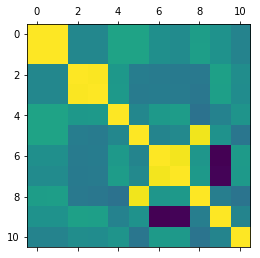

In [18]:
plt.matshow(daily.corr())

There are highly correlate features, some may be discarded. Moreover, some features are redondant.

In [19]:
del columns_descr["Chiffre d'Affaires HT"]

In [20]:
# extract numeric features
num_cols = [
    col 
    for col in columns_descr.keys()
    if np.isreal(daily.loc[start_date, col])
]
num_cols
#scatter_matrix(daily)

["Chiffre d'Affaires TTC",
 'Nombre moyen de produits / Ticket',
 'Ticket moyen TTC',
 'date',
 'dow',
 'day',
 'month',
 'week number',
 'month week number',
 'year',
 'public holidays']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff779b6940>,
      dtype=object)

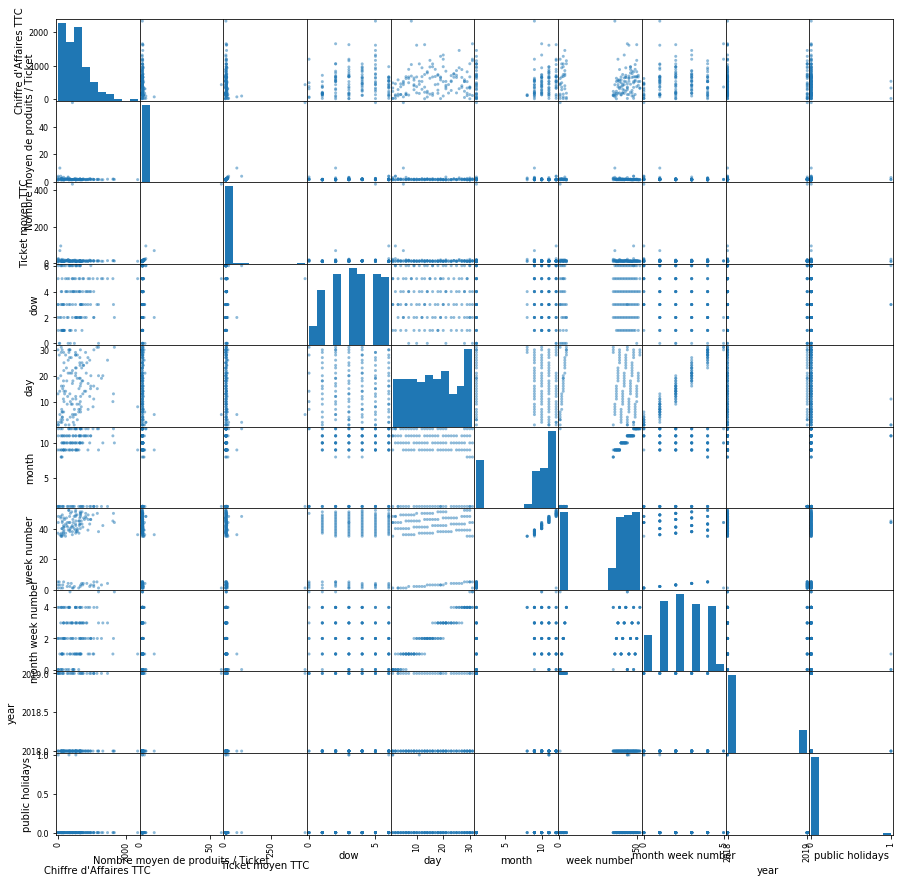

In [21]:
scatter_matrix(daily.loc[:, num_cols], figsize=(15, 15))

 * The Income seems to vary each month
 * There are outliers in income
 * Mean product per transaction and mean transaction number is highly correlated (as expected) except for some days (must be treated separately)
 

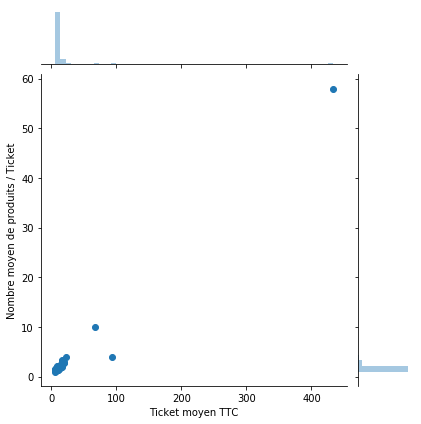

In [22]:
sns.jointplot(
    data=daily,
    x="Ticket moyen TTC",
    y="Nombre moyen de produits / Ticket", 
)

* 3 days with higher mean transaction
* 1 day with the mean product price is higher than usual

### Transaction outliers

The goal of this section is to know if this outliers should be discarded.

In [23]:
daily.loc[daily["Ticket moyen TTC"] > 60]

,Chiffre d'Affaires HT,Chiffre d'Affaires TTC,Nombre moyen de produits / Ticket,Ticket moyen TTC,date,dow,day,month,week number,month week number,year,public holidays
date,,,,,,,,,,,,
2018-09-05,56.00,67.2,10.0,67.2,2018-09-05,2,5,9,36,1,2018,0
2018-12-02,79.47,93.0,4.0,93.0,2018-12-02,6,2,12,48,0,2018,0
2019-01-05,361.99,433.8,58.0,433.8,2019-01-05,5,5,1,1,0,2019,0


One of this 3 outlier correspond to a privatisation. This individual will be discarded.

In [24]:
daily = daily.loc[daily["Ticket moyen TTC"] < 60]
# daily.head()

The opening day should alsobe discarded

In [25]:
daily.loc["2018-09-08"]

Chiffre d'Affaires HT                            1983.69
Chiffre d'Affaires TTC                              2339
Nombre moyen de produits / Ticket                    1.5
Ticket moyen TTC                                    8.57
date                                 2018-09-08 00:00:00
dow                                                    5
day                                                    8
month                                                  9
week number                                           36
month week number                                      1
year                                                2018
public holidays                                        0
Name: 2018-09-08 00:00:00, dtype: object

In [26]:
daily = daily[daily["date"] != "2018-09-08"]

###  Per  month income

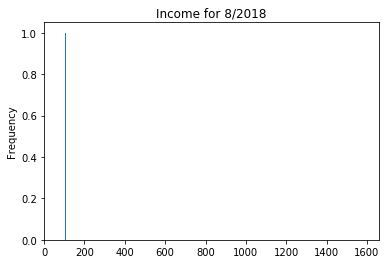

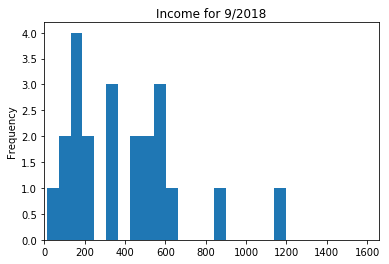

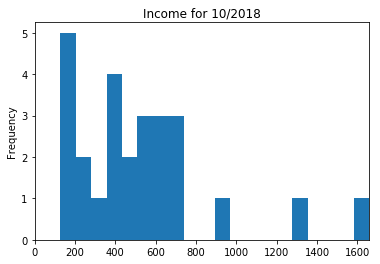

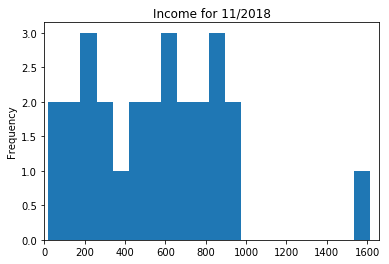

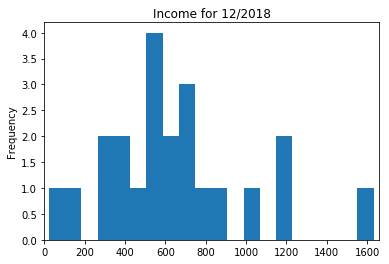

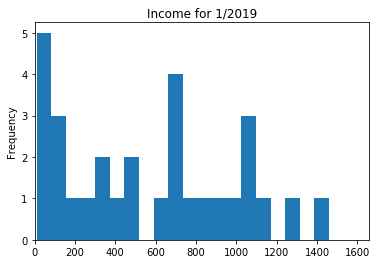

In [27]:
xlim = (0, max(daily["Chiffre d'Affaires TTC"]))
for year, month in product(range(2018, 2020), range(1, 13)):
    cur_data = daily.loc[(daily["month"] == month) & (daily["year"] == year)]
    if len(cur_data) == 0:
        continue
    plt.figure()
    #cur_data["Chiffre d'Affaires TTC"].plot(kind="box",) 
    cur_data["Chiffre d'Affaires TTC"].plot(
        kind="hist", 
        xlim=xlim, 
        title="Income for {}/{}".format(month, year),
        bins=20       
    )

For almost all month, there is one and only one day with high income

In [28]:
daily[daily["Chiffre d'Affaires TTC"] > 1500]

,Chiffre d'Affaires HT,Chiffre d'Affaires TTC,Nombre moyen de produits / Ticket,Ticket moyen TTC,date,dow,day,month,week number,month week number,year,public holidays
date,,,,,,,,,,,,
2018-10-31,1392.13,1659.2,1.6,9.88,2018-10-31,2,31,10,44,5,2018,0
2018-11-10,1370.21,1616.0,1.8,11.14,2018-11-10,5,10,11,45,1,2018,0
2018-12-13,1373.43,1632.4,1.9,12.75,2018-12-13,3,13,12,50,2,2018,0


Each month, one event help raising the income:
* 2018-09-08: opening
* 2018-10-31: halloween
* 2018-11-10: Nabla & JM
* 2018-12-13: Christmas co-plateau
* 2018-01-05: privatisation

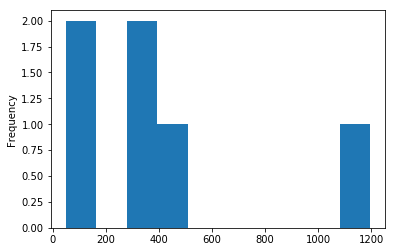

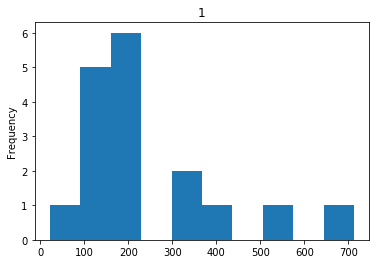

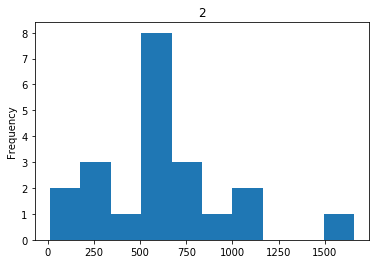

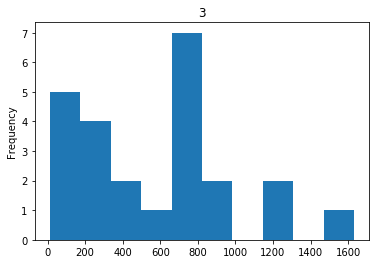

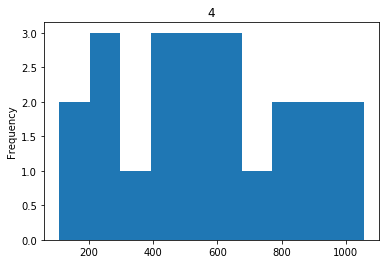

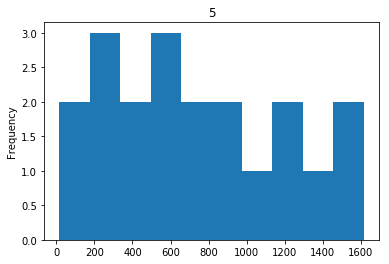

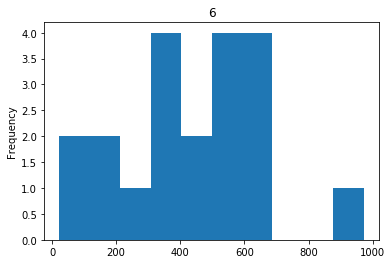

In [29]:
for title, group in daily.groupby("dow"):
    plt.figure()
    group["Chiffre d'Affaires TTC"].plot(kind="hist", title=title)

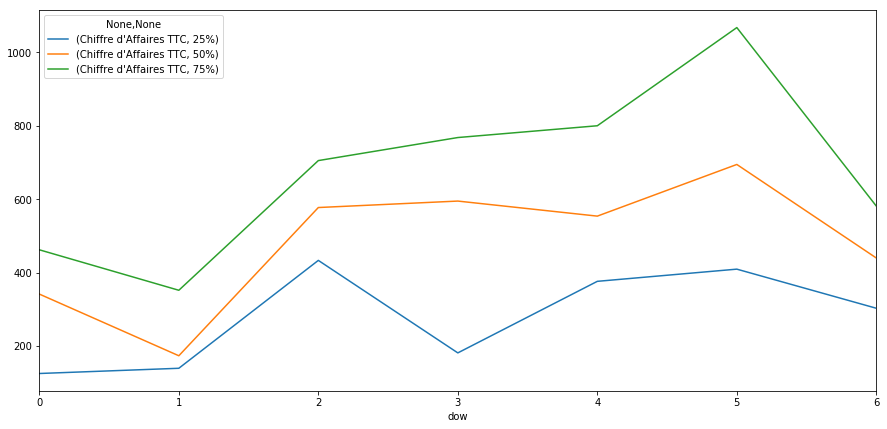

In [30]:
t = daily.loc[:, ["dow", "Chiffre d'Affaires TTC"]]
t = t.groupby("dow").describe()
# t.plot(figsize=(15,7))
t.iloc[:, [4, 5, 6]].plot(figsize=(15,7))

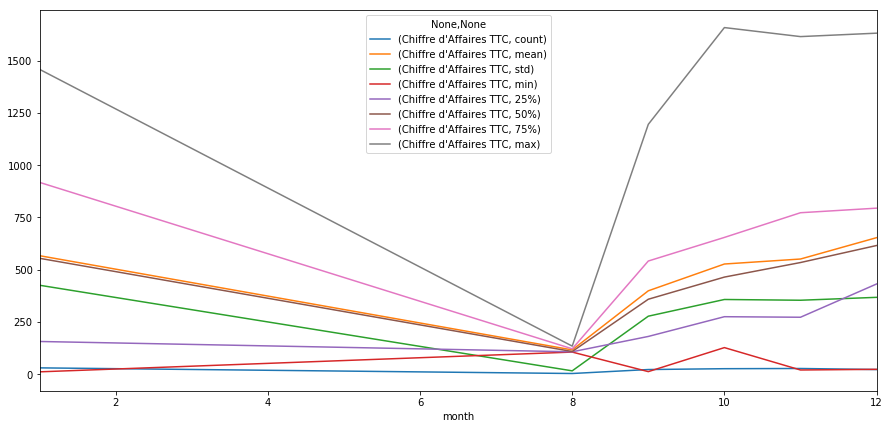

In [31]:
t = daily.loc[:, ["month", "Chiffre d'Affaires TTC"]]
t = t.groupby("month").describe()
t.plot(figsize=(15,7))

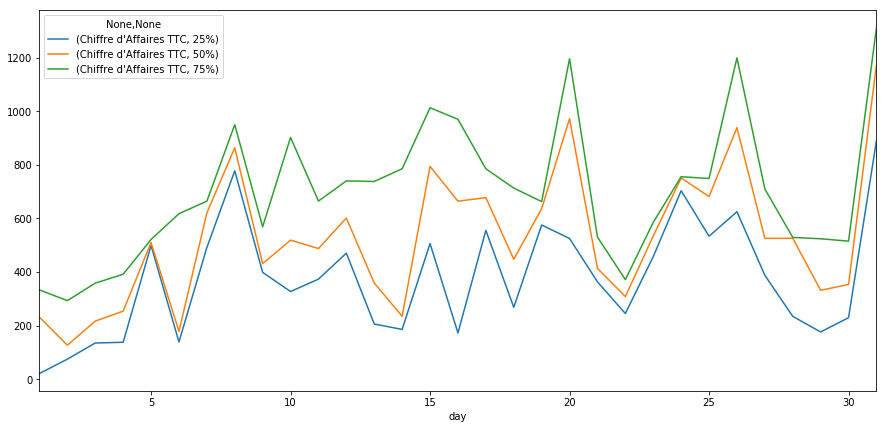

In [32]:
t = daily.loc[:, ["day", "Chiffre d'Affaires TTC"]]
t = t.groupby("day").describe()
#t.plot(figsize=(15,7))
t.iloc[:, [4, 5, 6]].plot(figsize=(15,7))

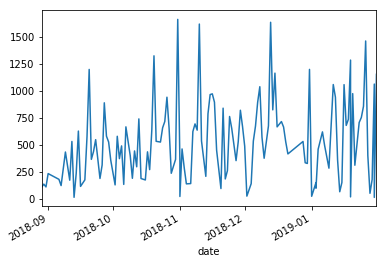

In [33]:
daily["Chiffre d'Affaires TTC"].plot()

This graph denote weekly seasonalities

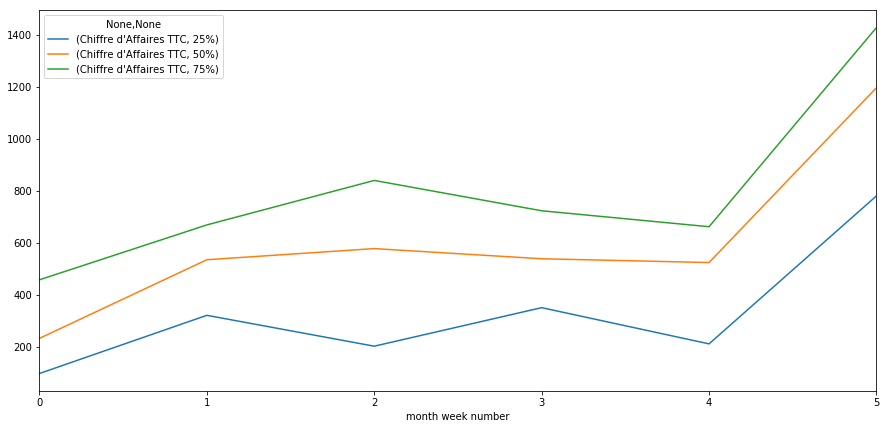

In [34]:
t = daily.loc[:, ["month week number", "Chiffre d'Affaires TTC"]]
t = t.groupby("month week number").describe()
#t.plot(figsize=(15,7))
t.iloc[:, [4, 5, 6]].plot(figsize=(15,7))

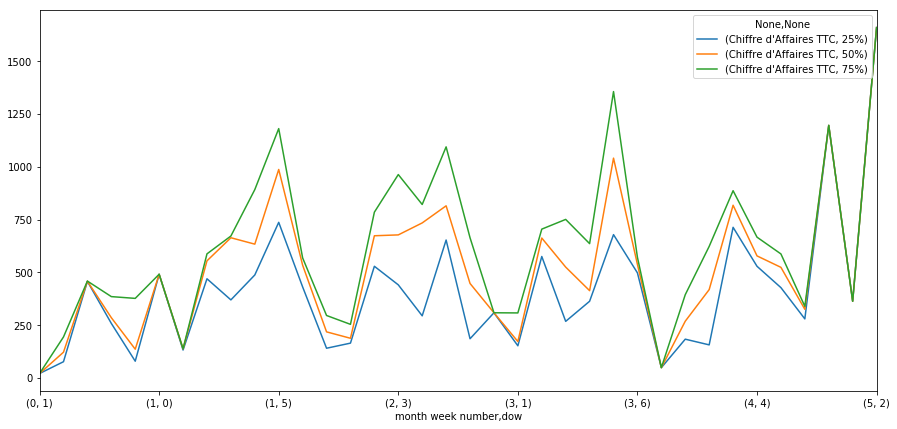

In [35]:
t = daily.loc[:, ["month week number", "dow", "Chiffre d'Affaires TTC"]]
t = t.groupby(["month week number", "dow"]).describe()

t.iloc[:, [4, 5, 6]].plot(figsize=(15,7))

The 1st friday after the 1st monday of each month is really a good day.

## Predictions

### time series analisis

In [36]:
from statsmodels.tsa.arima_model import ARIMA

clean serie

In [37]:
t = daily["Chiffre d'Affaires TTC"].resample('1D').mean()
t = t.interpolate()

zeros = pd.Series(0, index=[d for d in pd.date_range(start_date, end_date) if d not in open_days])
for day in zeros.index:
    t[day] = 0
t.head()
cleaned_daily = t

In [38]:
res = {}

#for order in product(range(2), repeat=3):
for order in product(range(31), range(2), range(31)):
    cleaned_ar = ARIMA(cleaned_daily, order=order)
    try:
        fitted = cleaned_ar.fit()
    except ValueError:
        continue
    # results = {
    #     "summary": fitted.summary(), 
    #     "quad_res": np.sum(np.power(fitted.resid, 2))
    # }
    res[order] = np.power(fitted.resid, 2)
errors = pd.DataFrame(res).describe()

/usr/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid val

LinAlgError: SVD did not converge

In [ ]:
errors

### other methods